In [169]:
import torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch import optim
import time

batch_size = 32
nb_categories = 101


In [170]:
data_root = '/home/wenjian/data4/'

train_set_dir = data_root + 'wiki_crop_train/'
val_set_dir = data_root + 'wiki_crop_val/'
test_set_dir = data_root + 'wiki_crop_test/'

result_dir = '/home/wenjian/results/'

In [171]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])]) # Imagenet standards

val_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])]) # Imagenet standards

# What should we do for test??????
test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor()])

train_set = ImageFolder(train_set_dir, transform=train_transform, target_transform=None)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = ImageFolder(val_set_dir, transform=val_transform, target_transform=None)
val_loader = DataLoader(val_set, batch_size=batch_size)

test_set = ImageFolder(test_set_dir, transform=test_transform, target_transform=None)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [172]:
VGGmodel = models.vgg16(pretrained=True)
for param in VGGmodel.parameters():
    param.requires_grad = False
# The original classifier[6]'s input features
n_inputs = VGGmodel.classifier[3].out_features
# Add on classifier
VGGmodel.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(512, nb_categories),                   
                      nn.Softmax())
  

Input size of the image 256 256 3

In [173]:
class Flatten(nn.Module):
    def forward(self, input_tensor):
        return input_tensor.view(input_tensor.size(0), -1)

In [174]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4))
        self.layer4 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            Flatten(),
            nn.Linear(9*1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 101),
            nn.Softmax())
        
    def forward(self, x):
        #print('---0---', x.shape)
        x = self.layer1(x)
        #print('---1---', x.shape)
        x = self.layer2(x)
        #print('---2---', x.shape)
        x = self.layer3(x)
        #print('---3---', x.shape)
        x = self.layer4(x)
        return x

In [175]:
model = VGGmodel
criterion = nn.KLDivLoss()
optimizer = optim.Adam(model.parameters())

In [176]:
def linear_shadow(label_batch, gap=0.2, nb_categories=101):
    batch_size = label_batch.shape[0]
    l = torch.zeros(batch_size, nb_categories, dtype= torch.float)
    for i in range(batch_size):
        label = torch.tensor(label_batch[i], dtype=torch.float)
        for j in range(nb_categories):
            l[i,j] = 1- abs(label-j)*gap
            if l[i,j]<0:
                l[i,j]=0
    return l

In [177]:
def target_distribution(vectors):
    # To normalize the distribution. Shape of the vectors are expected as (batch_size, vector_dim)
    # Noted that the softmax function in Pytorch only work for float type tensor
    return nn.functional.softmax(vectors, dim=1)

https://github.com/pytorch/examples/blob/master/mnist/main.py

In [178]:
def train(model, train_loader, criterion, optimizer, epoch):
    print('Start training...')
    model.train()
    log_interval = 10
    losses = []
    with open(result_dir + 'training_log.txt', 'a') as f: 
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            out = model(data)
            log_proba = torch.log(out)
            labels = linear_shadow(labels)
            labels = target_distribution(labels) # Normalize the distribution
            loss = criterion(log_proba, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                f.write('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    return losses

In [179]:
def validate(model, val_loader):
    print("Start validation...")
    model.eval()
    test_loss = 0.0
    diff = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            out = model(data)
            log_proba = torch.log(out)
            labels = linear_shadow(target)
            labels = target_distribution(labels) # Normalize th distribution
            test_loss += criterion(log_proba, labels)
            preds = out.argmax(dim=1, keepdim=True)
            diff += nn.functional.l1_loss(preds.float(), target.float()) #nn.functional.l1_loss output the average l1 distance by default
            
    test_loss /= len(test_loader.dataset)
    diff /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, diff: {}\n'.format(test_loss, diff))
    with open(result_dir + 'validation_log.txt', 'a') as f:
        f.write('\nTest set: Average loss: {:.4f}, diff: {}\n'.format(test_loss, diff))
    return test_loss, diff


In [ ]:
import numpy as np


n_epochs = 20
train_losses_all = []
val_loss_all = []
val_diff_all = []
for epoch in range(n_epochs):
    print(epoch,'th epoch started...')
    epoch_start = time.time()
    train_losses = train(model, train_loader, criterion, optimizer, epoch)
    train_losses_all.append(train_losses)
    val_loss, diff = validate(model, val_loader)
    val_loss_all.append(val_loss)
    val_diff_all.append(diff)
    torch.save(model.state_dict(),"model_trained_" + str(epoch) + ".pt")

    train_loss_array = np.array(train_losses_all)
    val_loss_array = np.array(val_loss_all)
    val_diff_array = np.array(val_diff_all)

    np.save(result_dir + 'train_loss_array.npy', train_loss_array)
    np.save(result_dir + 'val_loss_array.npy', val_loss_array)
    np.save(result_dir + 'val_diff_array.npy', val_diff_array)
    
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    print(epoch, 'th epoch time: ', epoch_time)

0 th epoch started...
Start training...


/home/wenjian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/wenjian/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Train Epoch: 0 [0/4138 (0%)]	Loss: 0.000490
Train Epoch: 0 [320/4138 (8%)]	Loss: 0.000249
Train Epoch: 0 [640/4138 (15%)]	Loss: 0.000248
Train Epoch: 0 [960/4138 (23%)]	Loss: 0.000245
Train Epoch: 0 [2560/4138 (62%)]	Loss: 0.000242
Train Epoch: 0 [2880/4138 (69%)]	Loss: 0.000238
Train Epoch: 0 [3200/4138 (77%)]	Loss: 0.000247
Train Epoch: 0 [3520/4138 (85%)]	Loss: 0.000240
Train Epoch: 0 [3840/4138 (92%)]	Loss: 0.000239
Start validation...

Test set: Average loss: 0.0000, diff: 0.8021881580352783

0 th epoch time:  513.2470374107361
1 th epoch started...
Start training...
Train Epoch: 1 [0/4138 (0%)]	Loss: 0.000239
Train Epoch: 1 [320/4138 (8%)]	Loss: 0.000238
Train Epoch: 1 [640/4138 (15%)]	Loss: 0.000234
Train Epoch: 1 [960/4138 (23%)]	Loss: 0.000240
Train Epoch: 1 [1280/4138 (31%)]	Loss: 0.000238
Train Epoch: 1 [1600/4138 (38%)]	Loss: 0.000242
Train Epoch: 1 [1920/4138 (46%)]	Loss: 0.000236
Train Epoch: 1 [2240/4138 (54%)]	Loss: 0.000245
Train Epoch: 1 [2560/4138 (62%)]	Loss: 0.0002

In [154]:
from PIL import Image

In [157]:
def predict(model, img_name):
    img = Image.open(img_name)
    img = torchvision.transforms.functional.to_tensor(img)
    img = torchvision.transforms.functional.to_pil_image(img)
    img = torchvision.transforms.functional.resize(img, 256)
    five_imgs = torchvision.transforms.functional.five_crop(img, size=224)
    img = five_imgs[4] # Center crop
    img = torchvision.transforms.functional.to_tensor(img)
    #print('---aaa---', img.shape)
    batch_img = img.view(1, *(img.shape))
    #print('---bbb---', batch_img.shape)
    with torch.no_grad():
        out = model(batch_img)
        print(out)
        pred = out.argmax()
        print(pred)

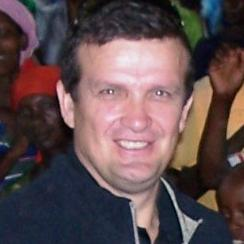

In [155]:
from IPython.display import Image as IPyImage
img_name = '/home/wenjian/data3/wiki_crop_test/48/10648596_1962-08-25_2010.jpg'
IPyImage(filename=img_name)

In [158]:
predict(model, img_name)

tensor([[0.0095, 0.0096, 0.0098, 0.0099, 0.0099, 0.0099, 0.0099, 0.0098, 0.0096,
         0.0096, 0.0095, 0.0095, 0.0095, 0.0095, 0.0096, 0.0097, 0.0097, 0.0097,
         0.0096, 0.0097, 0.0096, 0.0097, 0.0096, 0.0096, 0.0096, 0.0096, 0.0097,
         0.0097, 0.0097, 0.0097, 0.0097, 0.0098, 0.0097, 0.0097, 0.0096, 0.0095,
         0.0095, 0.0095, 0.0096, 0.0095, 0.0096, 0.0096, 0.0096, 0.0096, 0.0097,
         0.0098, 0.0098, 0.0098, 0.0097, 0.0097, 0.0097, 0.0098, 0.0097, 0.0098,
         0.0098, 0.0097, 0.0098, 0.0097, 0.0098, 0.0099, 0.0100, 0.0101, 0.0100,
         0.0102, 0.0101, 0.0101, 0.0101, 0.0102, 0.0100, 0.0101, 0.0101, 0.0102,
         0.0103, 0.0103, 0.0103, 0.0105, 0.0105, 0.0105, 0.0103, 0.0104, 0.0104,
         0.0104, 0.0105, 0.0106, 0.0108, 0.0107, 0.0107, 0.0106, 0.0106, 0.0105,
         0.0103, 0.0103, 0.0102, 0.0102, 0.0101, 0.0100, 0.0098, 0.0097, 0.0096,
         0.0095, 0.0094]])
tensor(84)


In [120]:
import matplotlib.pyplot as plt

In [45]:
a = torch.tensor([1,2,3])
b = torch.tensor([1.1, 2.5, 3.3])

In [46]:
nn.functional.l1_loss(a.float() ,b)

tensor(0.3000)